In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/stad.HRD_Score.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]

In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,1:608]
X_normalized = (X-X.mean())/X.std()

In [5]:
y = df.iloc[:,609]
print(np.sum(y))

66


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/STAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))


Number of Clusters: 23


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

78 78
79 79
79 79
0.28205128205128205
0.27848101265822783
0.27848101265822783


### Outer Loop 1

In [8]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(157, 607) (157,)
(79, 607) (79,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.6166117698726394, 0.6154150197628458, 0.6182806324110672, 0.6232433025911287, 0.6211901624945103, 0.6242973210364514, 0.6304677206851119, 0.6324440052700921, 0.6363636363636365, 0.6418862538427754, 0.651998243302591, 0.6655467720685111, 0.670718050065876, 0.6801932367149759, 0.6926548089591568, 0.6990228370663153, 0.7086407553798858, 0.7064888010540183, 0.698078612209047, 0.691677646025472, 0.6793368467281511, 0.6720245937637241, 0.6611769872639438, 0.6147891963109354, 0.5804567413263065, 0.5573671497584541, 0.5, 0.5, 0.5, 0.5]


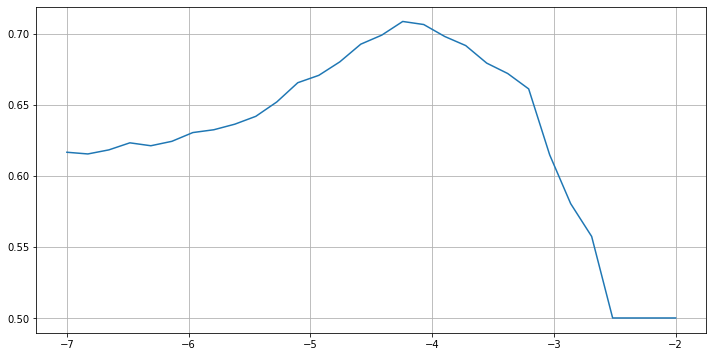

0.014387733001540358 -4.241379310344827


In [11]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.5
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

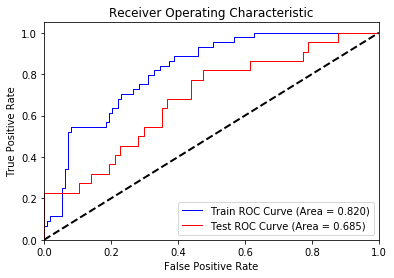

In [10]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

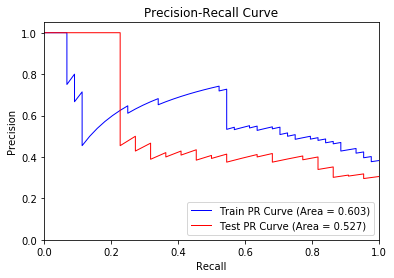

In [11]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 20


,HIF,Beta,Cluster
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.117895,17
396,DENSITY [CANCER CELLS] IN [EPITHELIAL]_HE,0.102776,2
553,REGION PROPERTIES: TOTAL FILLED AREA (MM2) OF NECROSIS_HE,0.050473,2
503,REGION PROPERTIES: PERIMETER (MM) OF LARGEST REGION OF NECROSIS_HE,0.041440,17
383,DENSITY RATIO [PLASMA CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.040959,2
215,COUNT PROP [LYMPHOCYTE CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.030284,15
377,DENSITY RATIO [MACROPHAGE CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.027839,2
433,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.018288,17
221,COUNT PROP [LYMPHOCYTE CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.016720,15
196,COUNT PROP [CANCER CELLS] IN [[STROMA] OVER [TUMOR]]_HE,0.000073,13


### Outer Loop 2

In [14]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(157, 607) (157,)
(79, 607) (79,)


In [37]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.5795783926218709, 0.5826416337285902, 0.5827184892402284, 0.5856170399648661, 0.5883948177426439, 0.5945212999560827, 0.5976723759332454, 0.5988032498902065, 0.6015920070267896, 0.5934453227931489, 0.5916776460254722, 0.5955314009661835, 0.6026679841897233, 0.6029424681598595, 0.6080259112867807, 0.6100351339481774, 0.6179732103645147, 0.6258344312692139, 0.6334980237154151, 0.6350351339481775, 0.6355292050944225, 0.659189723320158, 0.6760540184453229, 0.6838823012736056, 0.6961901624945103, 0.6982213438735178, 0.6979139218269653, 0.6907004830917874, 0.677832674571805, 0.6669301712779975]


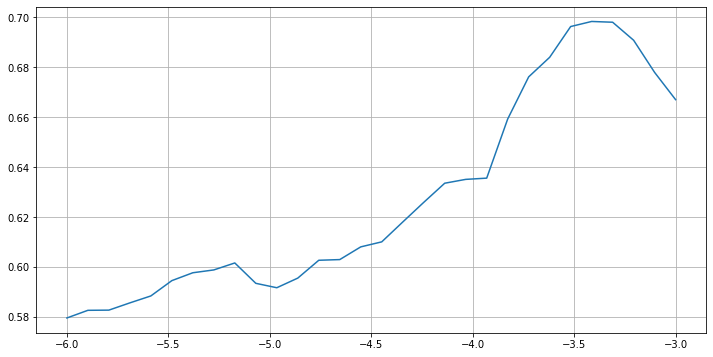

0.03291610907690537 -3.413793103448276


In [39]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.5
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

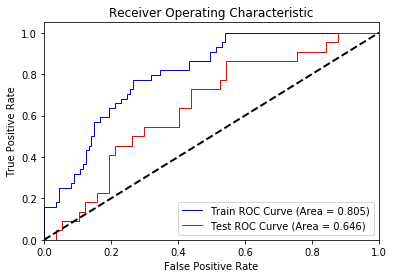

In [16]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

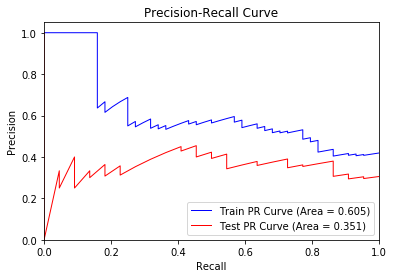

In [17]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 30


,HIF,Beta,Cluster
6,AREA PROP [[ESI_0080] OVER [TUMOR]] IN [TISSUE]_HE,0.261381,5
474,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF ESI_0080_HE,0.208291,5
46,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF PLASMA IN STROMA_HE,0.005600,1
569,REGION PROPERTIES: TOTAL PERIMETER (MM) OF STROMA_HE,0.003649,1
490,REGION PROPERTIES: MINOR AXIS LENGTH (MM) OF LARGEST REGION OF TUMOR_HE,0.001059,1
143,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF MACROPHAGE IN TUMOR_HE,-0.000353,1
132,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF FIBROBLAST IN EPITHELIAL_HE,-0.000995,1
595,TOTAL [LYMPHOCYTE CELLS] IN [EPITHELIAL]_HE,-0.001148,1
128,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF CANCER IN EPITHELIAL_HE,-0.001788,1
135,CELL CLUSTERING PROPERTIES: NUMBER OF CLUSTERS OF FIBROBLAST IN TUMOR_HE,-0.001997,1


### Outer Loop 3

In [19]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(158, 607) (158,)
(78, 607) (78,)


In [45]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.5644927536231883, 0.568401405357927, 0.5703337725076855, 0.5741985068072024, 0.580961791831357, 0.5830259112867809, 0.5917325428194994, 0.6005050505050505, 0.6052481335090031, 0.6138669301712781, 0.619631093544137, 0.6332894158981115, 0.6205314009661836, 0.6302481335090031, 0.6285573122529644, 0.6511638120333773, 0.6645476504172156, 0.661649099692578, 0.6602876592007026, 0.6621321914800176, 0.6612977602108037, 0.6627031181379007, 0.6706411945542381, 0.6741436100131752, 0.6802810715854195, 0.6758454106280194, 0.6631093544137021, 0.6701141853315766, 0.678425559947299, 0.6813350900307423]


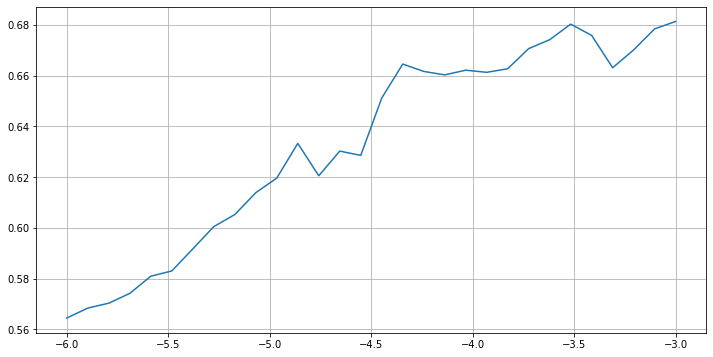

0.04978706836786395 -3.0


In [47]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.5
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

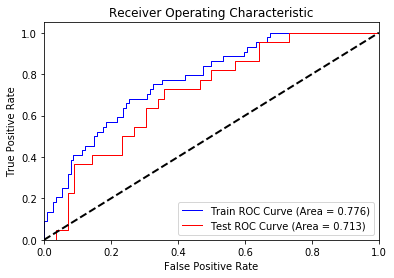

In [23]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

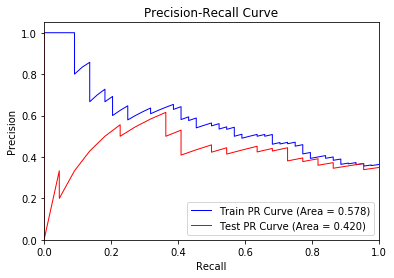

In [24]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 21


,HIF,Beta,Cluster
6,AREA PROP [[ESI_0080] OVER [TUMOR]] IN [TISSUE]_HE,0.054433,5
396,DENSITY [CANCER CELLS] IN [EPITHELIAL]_HE,0.053905,2
550,REGION PROPERTIES: TOTAL EULER NUMBER OF TUMOR_HE,0.049786,22
431,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,0.030543,20
377,DENSITY RATIO [MACROPHAGE CELLS] IN [[TUMOR] OVER [EPITHELIAL]]_HE,0.018572,2
383,DENSITY RATIO [PLASMA CELLS] IN [[ESI_0080] OVER [EPITHELIAL]]_HE,0.008361,2
506,REGION PROPERTIES: PERIMETER^2 / AREA OF EPITHELIAL_HE,0.007091,22
8,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN EPITHELIAL_HE,0.005128,6
50,CELL CLUSTERING PROPERTIES: CLUSTER EXTENT MEAN OF CANCER IN STROMA_HE,0.001794,6
10,CELL CLUSTERING PROPERTIES: BALL-HALL INDEX OF CANCER IN STROMA_HE,0.000339,6


## Compute Ensemble Model

In [26]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
6,AREA PROP [[ESI_0080] OVER [TUMOR]] IN [TISSUE]_HE,0.000000,0.261381,0.054433,5,0.105271
474,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF ESI_0080_HE,0.000000,0.208291,0.000000,5,0.069430
396,DENSITY [CANCER CELLS] IN [EPITHELIAL]_HE,0.102776,0.000000,0.053905,2,0.052227
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,0.117895,0.000000,0.000000,17,0.039298
553,REGION PROPERTIES: TOTAL FILLED AREA (MM2) OF NECROSIS_HE,0.050473,0.000000,0.000000,2,0.016824
...,...,...,...,...,...,...
547,REGION PROPERTIES: TOTAL EULER NUMBER OF ESI_0080_HE,0.000000,0.000000,-0.054740,22,-0.018247
548,REGION PROPERTIES: TOTAL EULER NUMBER OF NECROSIS_HE,-0.051821,0.000000,-0.030495,2,-0.027439
537,REGION PROPERTIES: STANDARD DEVIATION OF SOLIDITIES OF SIGNIFICANT REGIONS OF ESI_0080_HE,0.000000,-0.078841,-0.017051,5,-0.031964
497,REGION PROPERTIES: NUMBER OF SIGNIFICANT REGIONS OF ESI_0080_HE,0.000000,-0.099263,0.000000,5,-0.033088


## Compute Final Train / Test Metrics

In [27]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.8201930812550282, 0.8053097345132744, 0.7757177033492823]
0.8004068397058616 0.018485013625171163


In [28]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.6850079744816587, 0.645933014354067, 0.7126623376623377]
0.6812011088326878 0.02737480370519472


In [29]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.6032424963459526, 0.6052641568519832, 0.5783551002035201]
0.5956205844671519 0.012236407096412489


In [30]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.5273075610371495, 0.35093227300389507, 0.42009314821044996]
0.4327776607504982 0.0725613910239109


## Evaluate Hold-Out Set

In [31]:
holdout_df = pd.read_csv("{0}/data/genetic_data/HRD/datasets/stad.HRD_Score.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,bcr_patient_barcode,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,...,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,HRD_Score,HRD_Score_Binarized
0,TCGA-FP-7735,8.061936,8.205972,0.484000,9.612336,17.674272,5960.750045,6015.158862,5035.768153,5661.540493,...,65.492954,104.679860,211.499057,144.899886,46.887001,148.062899,304.816644,187.164710,46,1
1,TCGA-FP-7829,20.967920,26.908096,4.562176,9.960640,30.928560,7276.155102,7109.897710,7162.881625,7587.011393,...,53.224163,107.774255,344.957754,147.177883,13.449117,117.696919,322.067658,112.840688,44,1
2,TCGA-FP-7916,5.561952,15.443124,0.145216,19.614880,25.176832,5809.600670,6343.137744,6323.425989,6622.191015,...,52.319761,109.369063,191.283352,160.584143,82.884570,208.636543,328.118245,273.942329,10,0
3,TCGA-FP-7998,8.840400,14.701344,0.596208,12.003328,20.843728,6607.093302,6781.979545,6280.097632,7077.515147,...,82.349215,152.230980,272.840999,192.048179,648.047600,725.375857,906.998459,797.170257,11,0
4,TCGA-FP-8099,2.824304,7.961844,0.021408,13.157760,15.982064,5606.511459,5305.557452,5696.184195,6130.182737,...,12.038364,27.882988,38.456394,33.787876,45.674970,133.888582,150.785544,132.210708,39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,TCGA-VQ-AA6F,105.665040,183.396776,4.844480,135.345968,241.011008,7097.986120,6935.958813,6512.172073,7193.044989,...,55.742183,69.630450,108.477557,85.357097,73.382833,135.869346,182.835147,134.848612,56,1
76,TCGA-VQ-AA6G,39.131056,63.708776,16.374176,61.549024,100.680080,5877.658131,6408.470450,5392.543322,5960.688470,...,42.242663,76.425891,198.524675,137.782966,17.888605,36.164562,131.894862,87.584356,16,0
77,TCGA-VQ-AA6I,76.872160,128.647732,1.674992,96.225184,173.097344,6079.464478,6367.159464,5947.752867,6346.569587,...,33.328061,96.861404,196.050547,123.785839,47.403377,116.978355,210.485438,138.061044,26,0
78,TCGA-VQ-AA6J,74.135744,102.547360,12.267408,92.817552,166.953296,6521.817916,6462.533081,5787.717947,6698.129215,...,21.163880,74.502162,184.695670,112.079249,20.745728,97.125855,174.708335,106.341117,44,1


In [32]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,1:608]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-1.213515,-1.414305,-0.669012,-1.383740,-1.512394,-0.770236,-0.735629,-1.304446,-1.620688,-0.797803,...,-0.202595,-0.276703,0.134731,0.085408,0.130772,0.169378,-0.240515,0.056873,0.220551,0.162638
1,-0.886988,-1.015652,-0.415027,-1.374981,-1.317750,1.329496,1.258736,2.324498,1.784797,0.987261,...,-1.408465,-1.386250,-0.088678,0.126204,1.228083,0.195452,-0.574520,-0.158043,0.300381,-0.362522
2,-1.276765,-1.260038,-0.690111,-1.132189,-1.402216,-1.011510,-0.138126,0.892352,0.078367,-0.196581,...,1.564769,2.248907,-0.105147,0.147229,-0.035444,0.348904,0.119058,0.485584,0.328381,0.775794
3,-1.193819,-1.275850,-0.662024,-1.323610,-1.465849,0.261497,0.661344,0.818432,0.883676,1.064416,...,1.819878,2.215551,0.441676,0.712310,0.635132,0.709048,5.764365,4.142817,3.007209,4.472832
4,-1.346029,-1.419508,-0.697821,-1.294577,-1.537245,-1.335694,-2.028361,-0.177749,-0.791824,0.404794,...,-1.143183,-0.683404,-0.838652,-0.927063,-1.292002,-1.102436,-0.252622,-0.043446,-0.492244,-0.225657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.255883,2.320047,-0.397446,1.778308,1.767390,1.045091,0.941859,1.214361,1.088008,1.680750,...,-0.403751,-0.291147,-0.042826,-0.376675,-0.716281,-0.512163,0.024147,-0.029427,-0.343931,-0.207018
76,-0.427453,-0.231212,0.320611,-0.077596,-0.293422,-0.902873,-0.019105,-0.695773,-1.091600,-0.248120,...,-0.791983,-0.635349,-0.288646,-0.287085,0.024095,0.087916,-0.530175,-0.735090,-0.579663,-0.540979
77,0.527412,1.153021,-0.594838,0.794468,0.770052,-0.580737,-0.094364,0.251438,-0.409111,0.056313,...,0.158612,0.129802,-0.450977,-0.017669,0.003753,-0.072299,-0.235357,-0.163128,-0.215977,-0.184319
78,0.458179,0.596668,0.064846,0.708770,0.679825,0.125375,0.079385,-0.021588,0.212675,-0.100615,...,0.491722,0.353505,-0.672481,-0.312447,-0.089608,-0.206295,-0.501636,-0.303635,-0.381539,-0.408447


In [33]:
y_holdout = holdout_df.iloc[:,609]
print(np.sum(y_holdout))

40


In [34]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [35]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

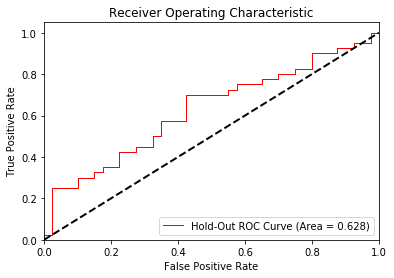

In [36]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.628


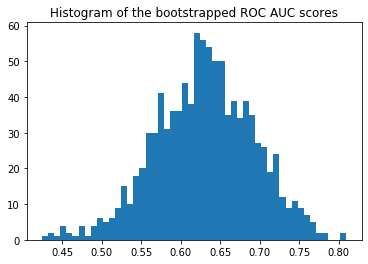

Confidence interval for the score: [0.501 - 0.75]


In [37]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

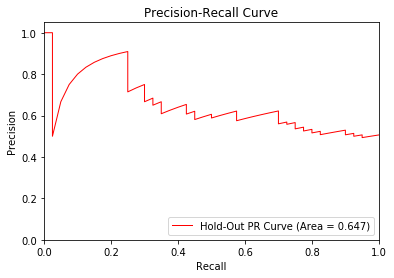

In [38]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.647


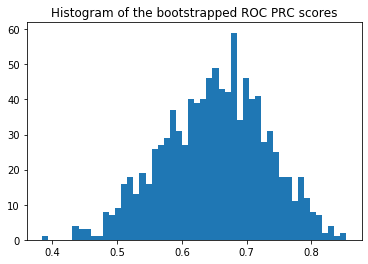

Confidence interval for the score: [0.494 - 0.797]


In [39]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))